In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import gym
import gym_minigrid
from gym_minigrid.wrappers import *
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from tqdm import tqdm
from time import sleep
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from control.replay import Transition, ReplayMemory, Episode, EpisodeReplayMemory
import models.rnn as rnn
import models.attentive as attentive

from control.agents import DQNAgent
import environment.grids as grids

In [2]:
class CustomImgObsWrapper(ImgObsWrapper):
    """
    Flatten the output.
    """

    def observation(self, obs):
        return torch.flatten(torch.tensor(super(CustomImgObsWrapper, self).observation(obs)))

class CustomFullyObsWrapper(FullyObsWrapper):
    """
    Flatten the output.
    """

    def observation(self, obs):
        return torch.flatten(torch.tensor(super(CustomFullyObsWrapper, self).observation(obs)))

In [112]:
#env = gym.make('CartPole-v0') #.unwrapped

# env = gym.make('MiniGrid-Empty-4x8-v0')
env = grids.CustomEmptyEnv(height=3, width=16, noise=0)
env = CustomFullyObsWrapper(env)

#env = gym.make('MiniGrid-Empty-Random-6x6-v0')
#env = CustomImgObsWrapper(env)

#env = gym.make('MiniGrid-FourRooms-v0')
#env = CustomImgObsWrapper(env)

#env = gym.make('MiniGrid-DoorKey-8x8-v0')
#env = CustomImgObsWrapper(env)

#env = gym.make('MiniGrid-LavaCrossingS9N3-v0')
#env = CustomImgObsWrapper(env)

#env = gym.make('MiniGrid-Empty-5x5-v0')
#env = AgentViewWrapper(env)
#env = CustomImgObsWrapper(env)

n_observations = np.prod(env.observation_space.shape)
n_actions = env.action_space.n

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [113]:
BATCH_SIZE = 32 # 128
GAMMA = 0.9 # 0.9
N_EPISODES = 1000 # 1000
MAX_T = 40 # 200
EPS_START, EPS_END, EPS_DECAY = 0.5, 0.05, 50000 # 0.3, 0.05, 10000
TARGET_UPDATE = 10 # 10
SEGMENT = 10 # 10
N_TESTS = 1 # 1
LR = .0001 # .0001
HIDDEN_DIMENSIONS = [100, 10]
SIZE_REPLAY = 100 # 10000

USE_MEMORY_ATTENTION = False
ATTENTION_K = 5
ATTENTION_T = 1
ALPHA, BETA = 0.5, 0.5

In [114]:
model_parameters = dict(
    network_type='mlp',
    input_dimension=n_observations,
    hidden_dimensions=HIDDEN_DIMENSIONS,
    output_dimension=n_actions
)

class DQN(nn.Module):

    def __init__(self, input_dimension, hidden_dimensions, output_dimension, network_type='mlp'):
        super(DQN, self).__init__()
        
        self.network_type = network_type
        
        if network_type == 'mlp':
            self.model = nn.Sequential(
            nn.Sequential(
                nn.Linear(input_dimension, hidden_dimensions[0]),
                nn.ReLU(),
            ),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dimensions[i], hidden_dimensions[i+1]),
                    nn.ReLU(),
                )
                for i in range(len(hidden_dimensions)-1)
            ],
            nn.Linear(hidden_dimensions[-1], output_dimension),
        )
            
        elif network_type == 'att':
            self.model = attentive.Attentive(input_dim=4, hidden_dimensions=(64, 64, 64, 64), 
                                             memory_size=256, memory_dimension=32, 
                                             key_dimension=16, output_dim=2)
        else:
            self.model = rnn.RNN(input_dimension=4, hidden_dimension=hidden_dimension // 2, n_actions=2, dropout=0)

    def forward(self, x, mask=None):
        if self.network_type in {'mlp', 'att'}:
            return self.model(x)
        else:
            return self.model(x, mask)
    
    def reset(self):
        if self.network_type == 'rnn':
            self.model.reset()
            
    def predict(self, x):
        if self.network_type in {'mlp', 'att'}:
            return self.model(x)
        else:
            return self.model.predict(x)

In [119]:
policy_net = DQN(**model_parameters).to(device)
target_net = DQN(**model_parameters).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# optimizer = optim.SGD(policy_net.parameters(), lr=.001)
# optimizer = optim.Adam(policy_net.parameters(), lr=.00001, betas=(.9, .99))
optimizer = optim.RMSprop(policy_net.parameters(), lr=LR)
# optimizer = eligibility.EligibilitySGD(policy_net.parameters(), lr=.9, gamma=.9, lambd=.9)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.5)

memory = ReplayMemory(SIZE_REPLAY)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net.predict(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def select_action_greedy(state):
    with torch.no_grad():
        return policy_net.predict(state).max(1)[1].view(1, 1)

    
# durations_train, durations_test = [], []
full_returns_train, full_returns_test, full_returns = [], [], []
initial_predictions = []
epsilons, eps = [], []


# def plot_durations(max_points=N_EPISODES//SEGMENT, mean_window=1):
    
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     plt.figure(1)
#     plt.clf()

#     durations_train = torch.tensor(durations_train, dtype=torch.float)
#     durations_test = torch.tensor(duration_test, dtype=torch.float)
#     t = np.arange(len(durations_train))

#     plt.title('Training...')
#     plt.xlabel('Segments')
#     plt.ylabel('Returns')
    
#     #plt.plot(t[-max_points:], returns_train.numpy()[-max_points:], label='train')
#     #plt.plot(t[-max_points:], returns_test.numpy()[-max_points:], label='test')

#     if len(returns_train) >= mean_window:
#         means = durations_train.unfold(0, mean_window, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(mean_window-1), means))
#         plt.plot(t[-max_points:], means.numpy()[-max_points:], label='train')
        
#         means = durations_test.unfold(0, mean_window, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(mean_window-1), means))
#         plt.plot(t[-max_points:], means.numpy()[-max_points:], label='test')

#     plt.legend()


def plot_returns(max_points=N_EPISODES//SEGMENT, mean_window=1):
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(1)
    plt.clf()

    returns_train = torch.tensor(full_returns_train, dtype=torch.float)
    returns_test = torch.tensor(full_returns_test, dtype=torch.float)
    t = np.arange(len(full_returns_train))

    plt.title('Training...')
    plt.xlabel('Segments')
    plt.ylabel('Returns')
    
    #plt.plot(t[-max_points:], returns_train.numpy()[-max_points:], label='train')
    #plt.plot(t[-max_points:], returns_test.numpy()[-max_points:], label='test')

    if len(returns_train) >= mean_window:
        means = returns_train.unfold(0, mean_window, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(mean_window-1), means))
        plt.plot(t[-max_points:], means.numpy()[-max_points:], label='train')
        
        means = returns_test.unfold(0, mean_window, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(mean_window-1), means))
        plt.plot(t[-max_points:], means.numpy()[-max_points:], label='test')

    plt.legend()

def plot_initial_predictions():
    
    #display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(2)
    plt.clf()

    predictions = [
        [
            initial_predictions[i][0][j] 
            for i in range(len(initial_predictions))
        ] for j in range(n_actions)
    ]
    t = np.arange(len(predictions[0]))

    plt.title('Training...')
    plt.xlabel('Segments')
    plt.ylabel('Initial prediction')
    
    for j in range(n_actions):
        plt.plot(t, predictions[j], label=str(j))

    plt.legend()
    
def plot_epsilon():
    
    #display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(3)
    plt.clf()
 
    t = np.arange(len(epsilons))

    plt.title('Training...')
    plt.xlabel('Segments')
    plt.ylabel('Epsilon')
    
    plt.plot(t, epsilons)

In [120]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    if not USE_MEMORY_ATTENTION:
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = policy_net(state_batch).gather(1, action_batch)

    else:
        tmp_state_action_values = policy_net(state_batch).gather(1, action_batch)
        states = torch.cat(Transition(*zip(*memory.memory)).state)

        unique_states, states_indices = states.unique(dim=0, return_inverse=True)

        # B x M
        similarity_vec = F.cosine_similarity(state_batch.unsqueeze(1), unique_states.unsqueeze(0), dim=-1)
        similarity_vec = torch.index_select(similarity_vec, dim=1, index=states_indices)

        # Computes the topk values and indices.
        values, indices = torch.topk(similarity_vec, dim=1, k=ATTENTION_K)

        # Obtains the softmax weights
        weights = F.softmax(values / ATTENTION_T, dim=1)

        # B x Ak x Ds
        similar_states = torch.index_select(states, dim=0, index=indices.view(-1))
        similar_states = similar_states.view(state_batch.size(0), ATTENTION_K, -1)

        # Computes the q value for everyone.
        q = policy_net(similar_states)

        value = (weights.unsqueeze(-1) * q).sum(1)
        value = value.gather(dim=1, index=action_batch)

        # trace_vals = []
        # for state, action in zip(state_batch, action_batch):
        #     similarity_vec = utils.compute_similarity(state, self.memory)
        #     state_trace_batch, batch_idx = self.memory.sample_states(num_samples=self.attention_k,
        #                                                              similarity_vec=similarity_vec)
        #     weights = F.softmax(similarity_vec[batch_idx])
        #     trace_vals.append(weights @ self.policy_net(state_trace_batch)[:, action])
        #
        # value = torch.stack(tensors=trace_vals)
        #
        # print((torch.abs(value - trace_value) < 1e-5).all())

        state_action_values = ALPHA * tmp_state_action_values + BETA * value

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [121]:
def train_episode(render=False):
    policy_net.reset()
    
    # Initialize the environment and state
    state = torch.tensor(env.reset()).float().unsqueeze(0)  #.unsqueeze(0)
    
    full_return = 0
    
    if render:
        env.render()
        sleep(0.1)
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        s, reward, done, _ = env.step(action.item())
        
        reward = torch.tensor([reward], device=device, dtype=torch.float)
        
        full_return += reward
        
        if t + 1 == MAX_T:
            done = True

        # Observe new state
        if not done:
            next_state = torch.tensor(s).float().unsqueeze(0)  #.unsqueeze(0)
        else:
            next_state = None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if render:
            env.render()
            sleep(0.1)
        
        if done:
            break
    
    return full_return

def test_episode(render=False):
    
    # Initialize the environment and state
    state = torch.tensor(env.reset()).float().unsqueeze(0)  #.unsqueeze(0)
    with torch.no_grad():
        initial_prediction = list(policy_net.predict(state))
    
    full_return = 0
    eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    if render:
        env.render()
        sleep(0.1)
        with torch.no_grad():
            print(policy_net.predict(state))
    
    for t in count():
        # Select and perform an action
        action = select_action_greedy(state)
        s, reward, done, _ = env.step(action.item())
        
        reward = torch.tensor([reward], device=device, dtype=torch.float)
        
        full_return += reward
        
        if t + 1 == MAX_T:
            done = True

        # Observe new state
        if not done:
            next_state = torch.tensor(s).float().unsqueeze(0)  #.unsqueeze(0)
        else:
            next_state = None

        # Move to the next state
        state = next_state
        
        if render:
            env.render()
            sleep(0.1)
            #with torch.no_grad():
            #    print(policy_net.predict(state))
        
        if done:
            break
        
    return full_return, eps, initial_prediction

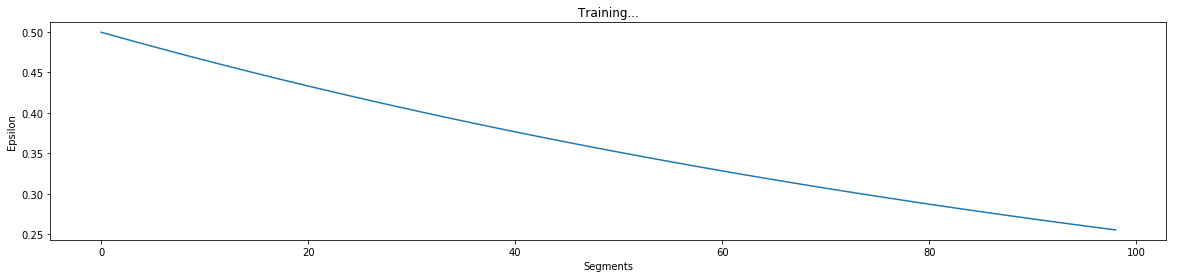

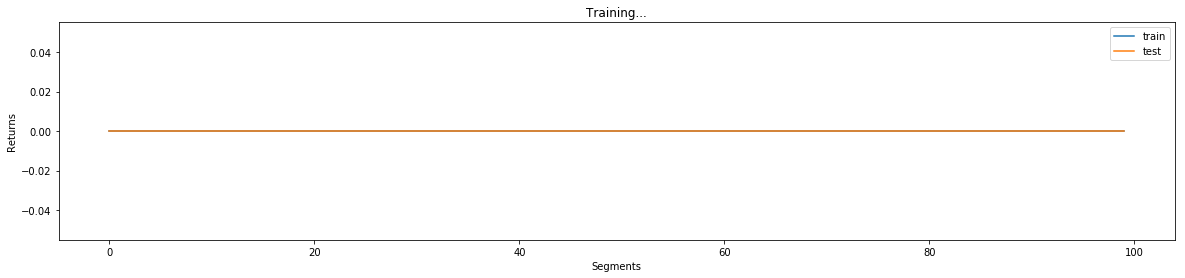

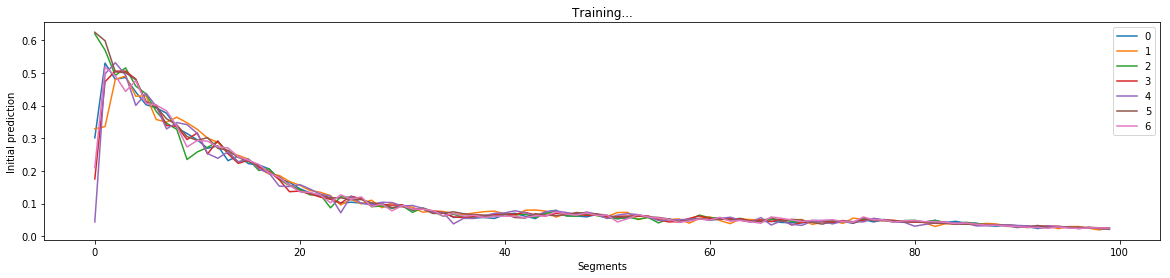

100%|###########################################################| 1000/1000 [02:09<00:00,  8.64it/s]


Complete


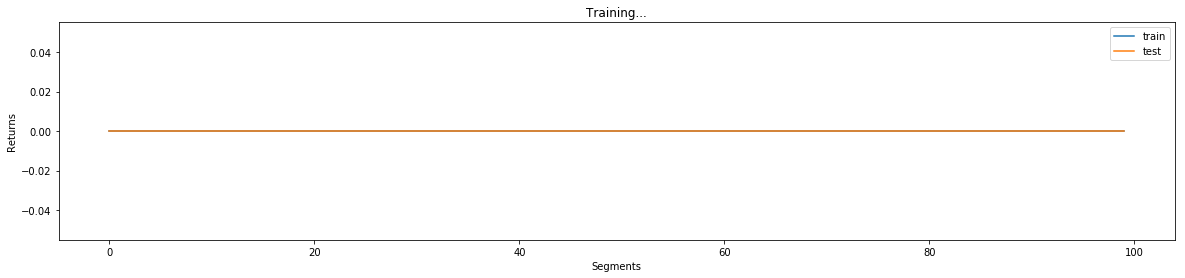

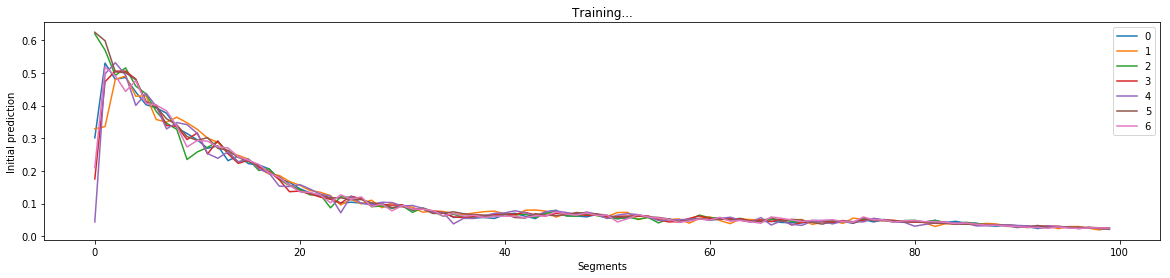

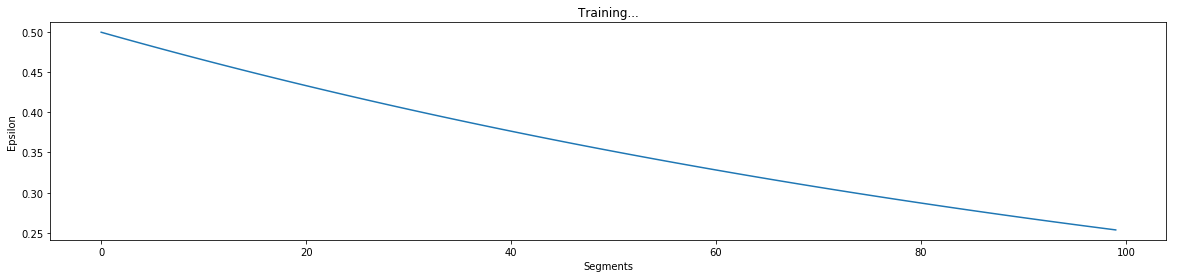

In [122]:
try:
    with tqdm(range(N_EPISODES), ascii=True, ncols=100) as episodes:
        for i_episode in episodes:

            full_return = train_episode()
            full_returns.append(full_return)

            if i_episode % SEGMENT == 0:
                full_returns_train.append(np.mean(full_returns))
                full_returns = []

                for _ in range(N_TESTS):
                    full_return, ep, pred = test_episode()
                    full_returns.append(full_return)

                    eps.append(ep)

                full_returns_test.append(np.mean(full_returns))
                epsilons.append(np.mean(eps))
                initial_predictions.append(pred)
                full_returns, eps = [], []

                # plot_durations(max_points=100)
                plot_returns(max_points=100)
                plot_initial_predictions()
                plot_epsilon()

            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            #scheduler.step()


    print('Complete')
    plt.ioff()
    plt.show()
except KeyboardInterrupt:
    pass

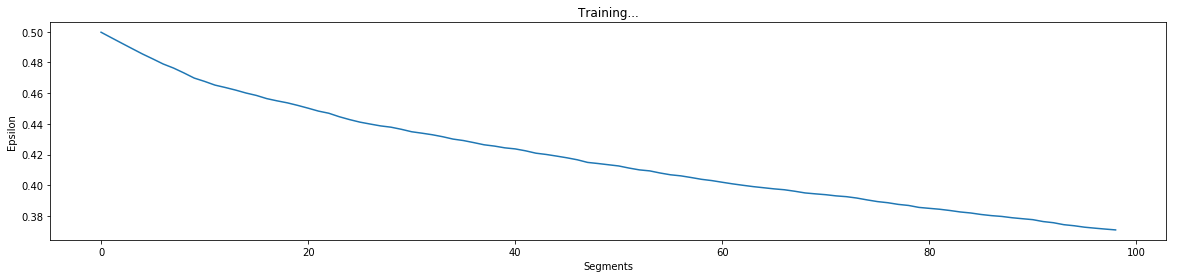

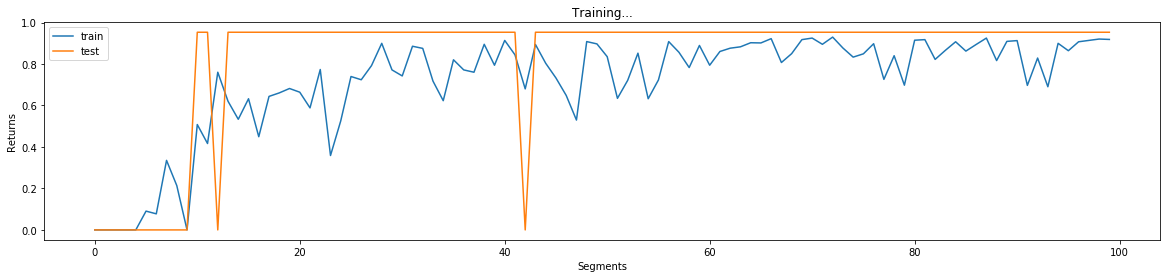

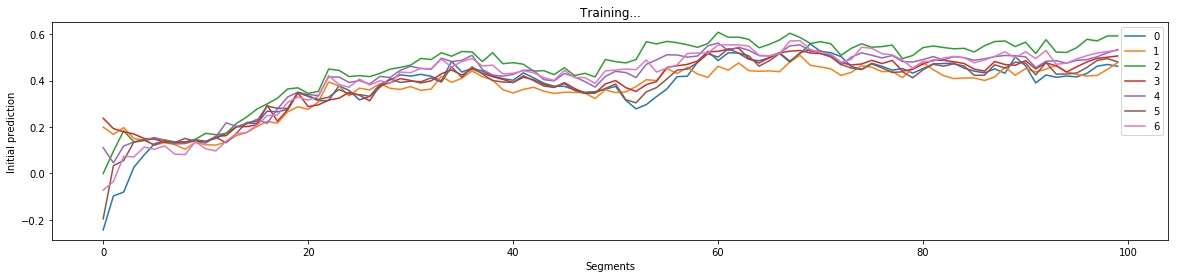

100%|###########################################################| 1000/1000 [01:28<00:00, 11.35it/s]


Complete


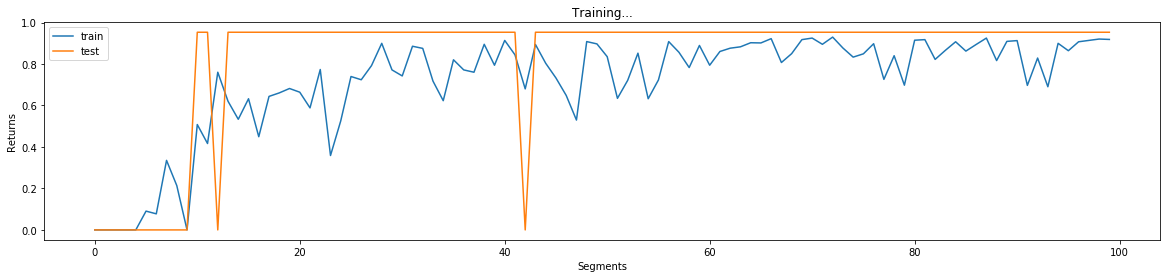

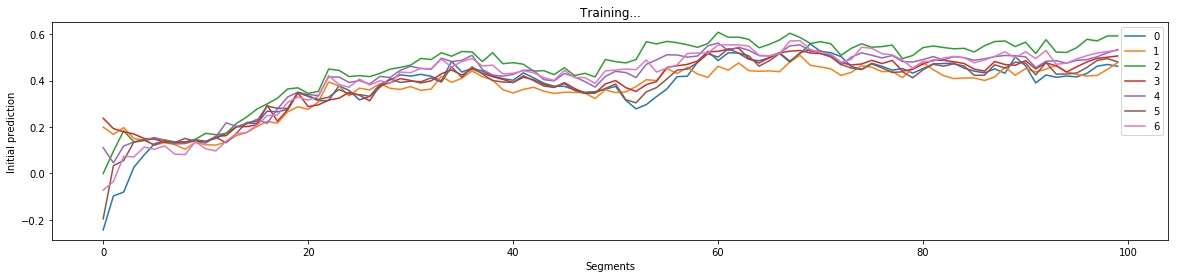

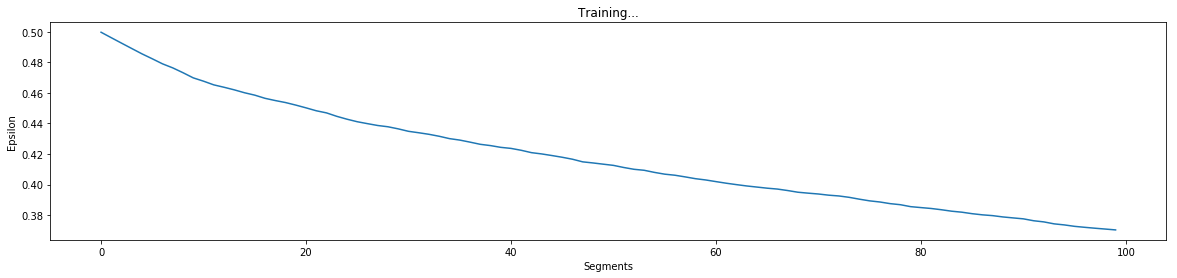

In [111]:
try:
    with tqdm(range(N_EPISODES), ascii=True, ncols=100) as episodes:
        for i_episode in episodes:

            full_return = train_episode()
            full_returns.append(full_return)

            if i_episode % SEGMENT == 0:
                full_returns_train.append(np.mean(full_returns))
                full_returns = []

                for _ in range(N_TESTS):
                    full_return, ep, pred = test_episode()
                    full_returns.append(full_return)

                    eps.append(ep)

                full_returns_test.append(np.mean(full_returns))
                epsilons.append(np.mean(eps))
                initial_predictions.append(pred)
                full_returns, eps = [], []

                # plot_durations(max_points=100)
                plot_returns(max_points=100)
                plot_initial_predictions()
                plot_epsilon()

            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            #scheduler.step()


    print('Complete')
    plt.ioff()
    plt.show()
except KeyboardInterrupt:
    pass

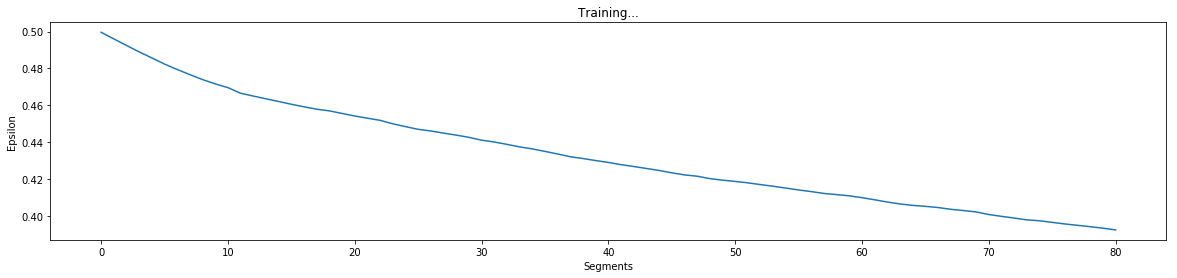

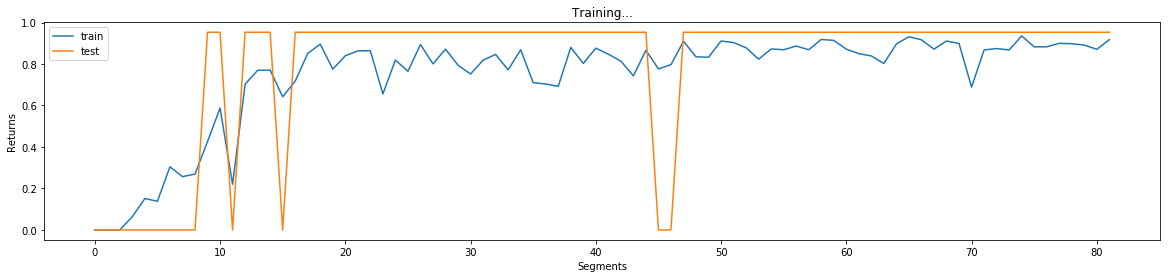

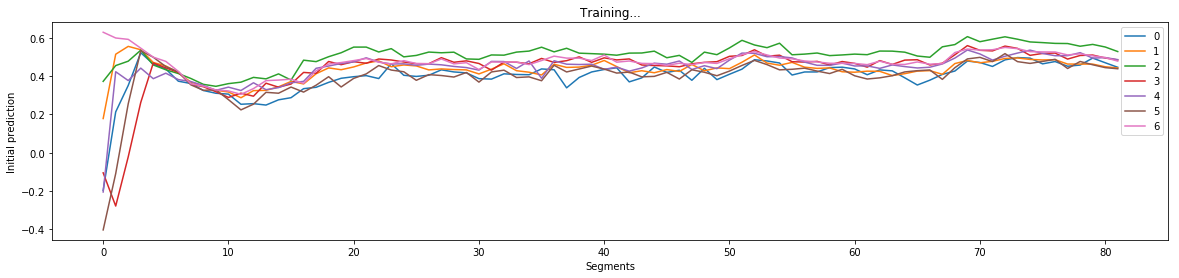

 82%|################################################9           | 815/1000 [01:38<00:15, 11.61it/s]

In [ ]:
try:
    with tqdm(range(N_EPISODES), ascii=True, ncols=100) as episodes:
        for i_episode in episodes:

            full_return = train_episode()
            full_returns.append(full_return)

            if i_episode % SEGMENT == 0:
                full_returns_train.append(np.mean(full_returns))
                full_returns = []

                for _ in range(N_TESTS):
                    full_return, ep, pred = test_episode()
                    full_returns.append(full_return)

                    eps.append(ep)

                full_returns_test.append(np.mean(full_returns))
                epsilons.append(np.mean(eps))
                initial_predictions.append(pred)
                full_returns, eps = [], []

                # plot_durations(max_points=100)
                plot_returns(max_points=100)
                plot_initial_predictions()
                plot_epsilon()

            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            #scheduler.step()


    print('Complete')
    plt.ioff()
    plt.show()
except KeyboardInterrupt:
    pass

<Figure size 1440x288 with 0 Axes>

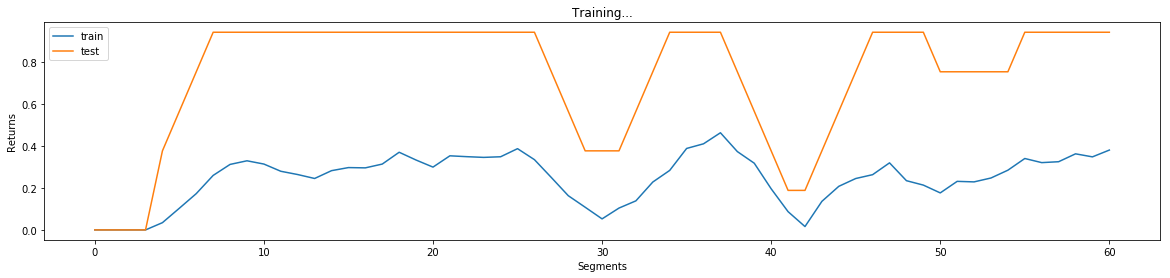

In [71]:
l = min(len(full_returns_train),len(full_returns_test))
full_returns_train = full_returns_train[:l]
full_returns_test = full_returns_test[:l]

plot_returns(mean_window=5)